In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Steps in data cleaning
- Remove unwanted columns
- Keep universities with more than 10 admits
- Keep majors with more than 10 entries
- Normalize GPA
- GRE score conversion
- Feature importance

In [2]:
data = pd.read_csv('../datasets/admission_data.csv')
data.head()

,userName,major,researchExp,industryExp,specialization,toeflScore,program,department,toeflEssay,internExp,...,termAndYear,confPubs,ugCollege,gmatA,cgpa,gmatQ,cgpaScale,gmatV,univName,admit
0,143saf,Systems and Control,0,18,Robotics,112.0,MS,Instrumentation & Control,26,5.0,...,Fall - 2015,0,Dharamsinh Desai University,NaN,8.50,NaN,10,NaN,Worcester Polytechnic Institute,1
1,7790ashish,Manufacturing Engineering,0,0,NaN,NaN,MS,0,NaN,0.0,...,Fall - 2013,0,NaN,NaN,0.00,NaN,0,NaN,Worcester Polytechnic Institute,1
2,AB25,(MIS / MSIM / MSIS / MSIT),0,66,NaN,94.0,MS,Computer Engineering,21,0.0,...,Fall - 2015,0,IET DAVV,NaN,78.28,NaN,100,NaN,Worcester Polytechnic Institute,1
3,abhijitg,NaN,0,0,NaN,NaN,NaN,0,NaN,0.0,...,NaN,NaN,NaN,NaN,0.00,NaN,0,NaN,Worcester Polytechnic Institute,1
4,abhijitgang,MIS,0,0,NaN,81.0,MS,computer,NaN,0.0,...,Fall - 2011,0,Pune University,NaN,57.00,NaN,100,NaN,Worcester Polytechnic Institute,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53644 entries, 0 to 53643
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   userName         53644 non-null  object 
 1   major            53257 non-null  object 
 2   researchExp      53644 non-null  int64  
 3   industryExp      53644 non-null  int64  
 4   specialization   31949 non-null  object 
 5   toeflScore       49230 non-null  float64
 6   program          53322 non-null  object 
 7   department       53643 non-null  object 
 8   toeflEssay       11874 non-null  object 
 9   internExp        53630 non-null  float64
 10  greV             52388 non-null  float64
 11  greQ             52424 non-null  float64
 12  userProfileLink  53644 non-null  object 
 13  journalPubs      53322 non-null  object 
 14  greA             50786 non-null  float64
 15  topperCgpa       53641 non-null  float64
 16  termAndYear      53322 non-null  object 
 17  confPubs    

<AxesSubplot:>

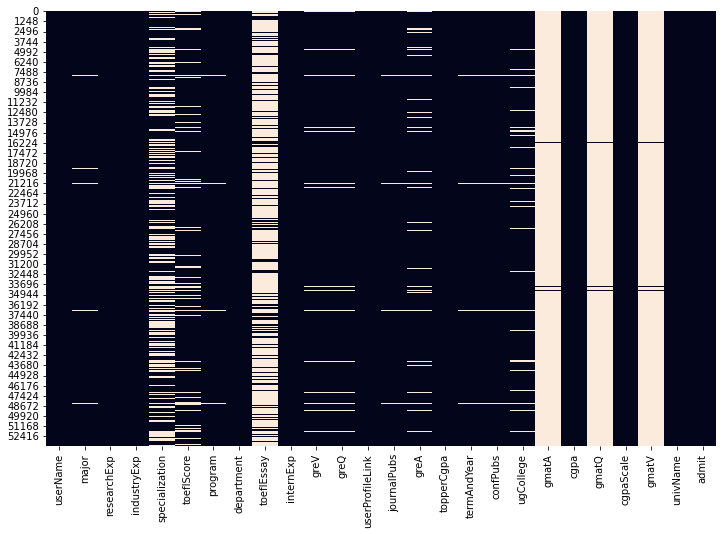

In [4]:
plt.figure(figsize=(12,8))
sns.heatmap(data.isnull(), cbar=False)

There is very limited data regarding GMAT scores

#### Removing unnecessary columns

In [5]:
# Dropping columns with many null values
null_cols = ['gmatA', 'gmatQ', 'gmatV', 'toeflEssay', 'specialization']
data.drop(null_cols, axis=1, inplace=True)

# Dropping unnecessary columns
unnecessary_cols = ['userName', 'userProfileLink', 'program', 'department', 'termAndYear', 'journalPubs', 'confPubs', 'internExp', 'topperCgpa', 'ugCollege']
data.drop(unnecessary_cols, axis=1, inplace=True)

data.columns

Index(['major', 'researchExp', 'industryExp', 'toeflScore', 'greV', 'greQ',
       'greA', 'cgpa', 'cgpaScale', 'univName', 'admit'],
      dtype='object')

#### Removing unnecessary rows

In [6]:
# Keep only admit rows
data = data[data['admit'] == 1]
data.drop('admit', axis=1, inplace=True)

In [7]:
# Keep universities with more than 10 admits
data = data.groupby('univName').filter(lambda x: len(x) > 10)
data['univName'].value_counts()

University of Texas Dallas                             2531
Arizona State University                               2122
SUNY Buffalo                                           1547
North Carolina State University                        1504
University of Southern California                      1409
Northeastern University                                1332
University of Illinois Chicago                         1280
University of Florida                                  1125
Carnegie Mellon University                              878
Syracuse University                                     867
University of Texas Arlington                           860
University of North Carolina Charlotte                  800
University of Cincinnati                                798
Texas A and M University College Station                790
SUNY Stony Brook                                        672
University of Arizona                                   672
University of Maryland College Park     

In [8]:
# Keep majors with more than 50 entries
print(data['major'].nunique())
data = data.groupby('major').filter(lambda x: len(x) > 50)
print(data['major'].nunique())
data['major'].unique()

235
35


array(['(MIS / MSIM / MSIS / MSIT)', 'MIS',
       'MIS-management related courses', 'Computer Science',
       'Mechanical Engineering', 'Electronics and Communication',
       'Information Systems', 'Human Computer Interaction',
       'Electrical Engineering', 'Information Technology',
       'Computer Engineering',
       'Computer Engineering / Computer Networking / Computer Science',
       'Telecommunication', 'Management Information System',
       'Industrial Engineering', 'Engineering Management',
       'Biomedical Engineering', 'Electrical and Computer Engineering',
       'Electrical Engg/ comp engg', 'CS / MSIS / ITM',
       'Civil Engineering', 'Aerospace Engineering',
       'Electrical & Computer Engineering', 'Bioinformatics',
       'Electrical and computer science', 'Chemical Engineering',
       'Electronics & Communication', 'Materials Science & Engineering',
       'Information Science', 'Electrical and Electronics',
       'Comp Science/Comp Networks/Comp Engg'

#### Normalize CGPA

In [9]:
data = data[data['cgpa'] < data['cgpaScale']]

In [10]:
data['cgpaNorm'] = data['cgpa']/data['cgpaScale']
data['cgpaNorm'].fillna(0, inplace=True)

In [11]:
data.drop(['cgpa', 'cgpaScale'], axis=1, inplace=True)

#### Convert GRE old scores to new scores

In [12]:
score_table = pd.read_csv('../datasets/score.csv', index_col='old')
score_table.head()

,newQ,newV
old,,
800,166,170
790,164,170
780,163,170
770,161,170
760,160,170


In [13]:
def updateGre(score, col):
    if(score > 170):
        try:
            newScore = score_table[col][score]
        except:
            newScore = None
        return newScore
    else:
        return score
        

In [14]:
data['greV'] = data['greV'].apply(updateGre, col='newV')
data['greQ'] = data['greQ'].apply(updateGre, col='newQ')

In [15]:
# Current max. score in GRE for each section is 170
data = data[data['greV']<=170]
data = data[data['greQ']<=170]
# Current min. score in GRE for each section is 130
data = data[data['greV']>=130]
data = data[data['greQ']>=130]

# For Analytical Writing max. score is 6.0
data = data[data['greA']<=6.0]

# Max. score in TOEFL is 120
data = data[data['toeflScore']<=120]
# Min. score in TOEFL is 60
data = data[data['toeflScore']>=60]

In [16]:
data.shape

(20864, 9)

#### Drop null columns

In [17]:
df = data.dropna()
print("Number of columns dropped:", data.shape[0] - df.shape[0])

Number of columns dropped: 0


<AxesSubplot:>

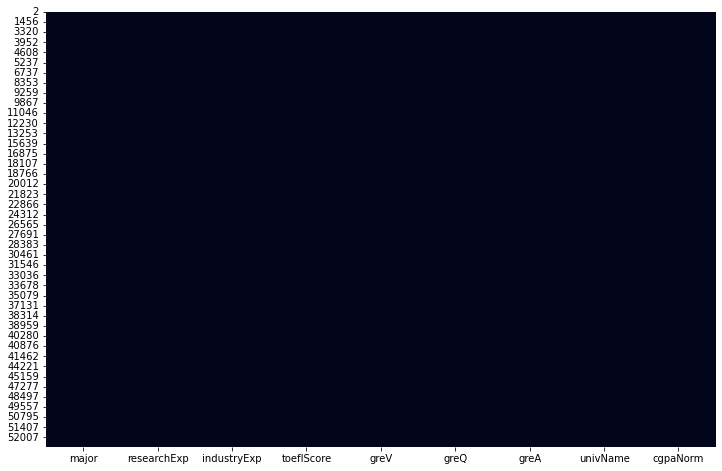

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(), cbar=False)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20864 entries, 2 to 52589
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   major        20864 non-null  object 
 1   researchExp  20864 non-null  int64  
 2   industryExp  20864 non-null  int64  
 3   toeflScore   20864 non-null  float64
 4   greV         20864 non-null  float64
 5   greQ         20864 non-null  float64
 6   greA         20864 non-null  float64
 7   univName     20864 non-null  object 
 8   cgpaNorm     20864 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 1.6+ MB


#### Feature importance

In [20]:
# one hot encoding the University names which is the target variable
y = df['univName']
Y = pd.get_dummies(y)

# Drop university name from dependent variable and one hot encode major 
x = df.drop('univName',axis=1);
X = pd.get_dummies(x)

In [21]:
X.describe()

,researchExp,industryExp,toeflScore,greV,greQ,greA,cgpaNorm,major_(MIS / MSIM / MSIS / MSIT),major_Aerospace Engineering,major_Bioinformatics,...,major_Information Science,major_Information Security,major_Information Systems,major_Information Technology,major_MIS,major_MIS-management related courses,major_Management Information System,major_Materials Science & Engineering,major_Mechanical Engineering,major_Telecommunication
count,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000,...,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000
mean,0.317916,3.538823,105.447421,154.624664,162.499329,3.611202,0.768987,0.005991,0.008148,0.002636,...,0.001773,0.004122,0.009538,0.001965,0.115127,0.005176,0.007717,0.002301,0.052291,0.009394
std,2.532673,11.123669,7.588290,6.206390,4.166972,0.566308,0.124441,0.077172,0.089900,0.051277,...,0.042075,0.064071,0.097198,0.044287,0.319182,0.071762,0.087507,0.047911,0.222619,0.096470
min,0.000000,0.000000,65.000000,130.000000,136.000000,1.500000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,101.000000,150.000000,160.000000,3.000000,0.706800,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,106.000000,155.000000,163.000000,3.500000,0.780000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,111.000000,159.000000,166.000000,4.000000,0.850000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,53.000000,126.000000,120.000000,170.000000,170.000000,6.000000,0.998000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X,Y)

ExtraTreesClassifier()

<AxesSubplot:>

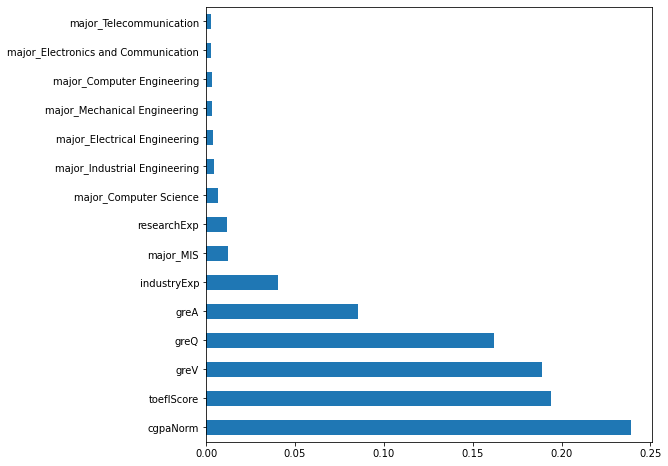

In [23]:
imp_features = pd.Series(model.feature_importances_, index=X.columns)
imp_features.nlargest(15).plot(kind='barh',figsize=(8,8))

In [24]:
df.head()

,major,researchExp,industryExp,toeflScore,greV,greQ,greA,univName,cgpaNorm
2,(MIS / MSIM / MSIS / MSIT),0,66,94.0,146.0,157.0,3.0,Worcester Polytechnic Institute,0.7828
4,MIS,0,0,81.0,148.0,161.0,2.5,Worcester Polytechnic Institute,0.5700
6,MIS,0,0,104.0,150.0,161.0,4.5,Worcester Polytechnic Institute,0.6220
7,MIS-management related courses,0,0,95.0,147.0,156.0,3.0,Worcester Polytechnic Institute,0.5200
8,MIS,0,0,101.0,152.0,158.0,3.0,Worcester Polytechnic Institute,0.6400


In [25]:
df['univName'].nunique()

52

There are 52 unique universities in final dataset

In [26]:
df.to_csv('../datasets/admission_data_cleaned.csv', index=False)